Let's get SU/RE trendlines
--

This notebook has the purpose of allowing others to collaborate on this research. 

This code is POC, not optimized, not even usable yet.



In [1]:
%matplotlib inline

from IPython.display import display, HTML

import os

import json

from pandas import DataFrame, Series, to_datetime, isna, notna
import numpy as np

import time
from datetime import datetime

path = '/home/bruno/Documentos/work/bitcoins/traders/freqtrade/user_data/data/binance/'
pair = 'ETH_BTC'
ticker_interval = '15m'
file = os.path.join(path, f'{pair}-{ticker_interval}.json')


with open(file) as tickerdata:
    pairdata = json.load(tickerdata)

# print (pairdata[-2])

def parse_ticker_dataframe(ticker: list) -> DataFrame:
    cols = ['date', 'open', 'high', 'low', 'close', 'volume']
    frame = DataFrame(ticker, columns=cols)

    frame['date'] = to_datetime(frame['date'],
                                unit='ms',
                                utc=True,
                                infer_datetime_format=True)

    # group by index and aggregate results to eliminate duplicate ticks
    frame = frame.groupby(by='date', as_index=False, sort=True).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'max',
    })
    frame.drop(frame.tail(1).index, inplace=True)     # eliminate partial candle
    return frame

/home/bruno/miniconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from scipy import linspace, polyval, polyfit, sqrt, stats, randn


from user_data.indicators.util import *
# from user_data.indicators.trendlines import *
from technical import indicators, util
import warnings
# warnings.filterwarnings("always")

# ZigZag

# This is inside your IPython Notebook
pyximport.install()
pyximport.install(reload_support=True)



def get_trends_OHCL(df: DataFrame, interval: int, tolerance: int, pivot_type: str, \
                     su_min_tests: int, re_min_tests: int, body_min_tests: int, \
                     ticker_gap: int, fake: int, nearby: int, angle_min: int, \
                     angle_max: int, thresh_up: int, thresh_down: int, \
                     chart=False, pair: str=None):
    ''' this approach is based on concurrence of points, either low high or body of candle'''

    start_time = time.time()
    print('finding trends by concurrence')

#     p = df.loc[df['pivots']==-1]

    df = get_fractals(df)
    p = df.loc[df[pivot_type]==-1]

    for i in range(0, len(p)-1):
        ax = p.index[i]
        ay = p.iloc[i].low


        next_waves = p[i+1:]

        for ib in range(0, len(next_waves)):
            # print (ib)
            bx = next_waves.index[ib]
            by = next_waves.iloc[ib].low

            t = df.index[bx:]

            # trace first trend
            slope, intercept, r_value, p_value, std_err = stats.linregress([ax, bx], [ay, by])
            trend = polyval([slope,intercept],t)
            angle = calculate_angle(ax, ay, bx, by)
            trend_name = 'trend|'+str(ax)+'|'+str(ay)+'|'+str(bx)+'|'+str(by)+'|'+str(round(angle))

            cond = angle >= angle_min and angle <= angle_max
            if cond:
                df.loc[bx:,trend_name] = trend
                df = get_line_tests(df, trend_name, pivot_type, nearby, fake)
                data_name = 'data_'+ trend_name

                re_name = data_name+'|re'
                su_name = data_name+'|su'
                body_name = data_name+'|body'

                if np.count_nonzero(np.where(df[su_name]==1)) >= su_min_tests:
#                     print (df.index[df[su_name]==1])
                    cx = df.index[df[su_name]==1][su_min_tests-1]
                    df.loc[ax:cx,trend_name] = np.nan
                else:
                    del df[trend_name]
                    del df[re_name]
                    del df[su_name]
                    del df[body_name]

    print("--- %s seconds ---" % (time.time() - start_time))
    return df

def get_trends_lightbuoy_OHCL(df: DataFrame, interval: int, tolerance: int, pivot_type: str, \
                     su_min_tests: int, re_min_tests: int, body_min_tests: int, \
                     ticker_gap: int, fake: int, nearby: int, angle_min: int, \
                     angle_max: int, thresh_up: int, thresh_down: int, \
                     chart=False, pair: str=None):

    ''' this approach focus on the lower/higher trend progressivelly. Currently plotting after 2nd point
    as the third is our validation and we might want to buy or sell if broken.

    '''

    start_time = time.time()
    print('finding trends - lightbuoy style')


    df = get_fractals(df)


    r = df.loc[df[pivot_type]==1]
    rx = r.index[0]
    ry = r.iloc[0].high
    df.loc[0:, 'r1_trend'] = ry

    s = df.loc[df[pivot_type]==-1]

    # just working with supports now.
    p = s
    last=len(p)-3
    i=0

    prev_ai = []
    ai = i
    ax = p.index[i]
    ay = p.iloc[i].low
    df.loc[0:,'s1_trend'] = ay

    b=True
    bx = p.index[i+1]
    by = p.iloc[i+1].low

    while b:

        # trace first trend

        t = df.index[ax:]
        slope, intercept, r_value, p_value, std_err = stats.linregress([ax, bx], [ay, by])
        trend = polyval([slope,intercept],t)
        angle = calculate_angle(ax, ay, bx, by)
        trend_name = 'trend|'+str(ax)+'|'+str(ay)+'|'+str(bx)+'|'+str(by)+'|'+str(round(angle))
        df.loc[ax:,trend_name] = trend
        df.loc[ax:,'s1_trend'] = trend


        df = get_line_tests(df, trend_name, pivot_type, nearby, fake)
        data_name = 'data_'+ trend_name

        re_name = data_name+'|re'
        su_name = data_name+'|su'
        body_name = data_name+'|body'

        cx = p.index[i+2]
        cy = p.iloc[i+2].low

        cond = angle >= angle_min and angle <= angle_max \
                and np.count_nonzero(df[su_name]) >= su_min_tests

        if cy <= (df.loc[cx][trend_name] * (1-fake)):
            # we can use this support broken as resistance but better do it after a confirmation
            if cond == True and (df.iloc[cx][trend_name] * (1-fake)) <= df.iloc[cx]['r1_trend']:
                df.loc[cx:,'r1_trend'] = df.loc[cx:,trend_name]
            if len(prev_ai)>0:
                ai = prev_ai.pop()
                ax = p.index[ai]
                ay = p.iloc[ai].low
            bx = cx
            by = cy
        elif cy > (df.loc[cx][trend_name] * (1+nearby)):
            if cond == True and (df.iloc[cx][trend_name] * (1+nearby)) >= df.iloc[cx]['s1_trend']:
                df.loc[bx:,'s1_trend'] = df.loc[cx:,trend_name]
            prev_ai.append(ai)
            ax = bx
            ay = by
            ai = i
            bx = cx
            by = cy
        else:
            bx = cx
            by = cy

        if i == last:
            b = False
        i += 1

    print("--- %s seconds ---" % (time.time() - start_time))
    return df


In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_trends(df, interval: int, pair: str=None, filename: str=None, cols=[]):
    plt.figure(num=0, figsize=(40,20))
    # df['old_date'] = df['date']
    # to_datetime(df['date'])
    # df.set_index(['date'],inplace=True)
#     for c in cols:
#         plt.scatter(df.index, df[c], color='r', label=c, s=10)
    
    if 's1_trend' in df:
        plt.plot(df['s1_trend'], color='g', label='support trend')
    if 'r1_trend' in df:
        plt.plot(df['r1_trend'], color='r', label='res trend')
    plt.plot(df.high, 'r', alpha=0.5)
    plt.plot(df.close, 'k', alpha=0.5)
    plt.plot(df.low, 'g', alpha=0.5)

#     plt.plot(df.bb_lower, 'b', alpha=0.5, linewidth=2)
#     plt.plot(df.bb_upper, 'b', alpha=0.5, linewidth=2)

    trends = [col for col in df if col.startswith('trend|')]
    for t in trends:
        plt.plot(df.index, df[t], 'k', label='trend', alpha=0.2, linewidth=1)
#         data_name = 'data_'+t+'|su'
#         if np.count_nonzero(np.where(df[data_name]==1)) > 2:
#             plt.plot(df.index, df[t], 'k', label='trend', alpha=0.5, linewidth=1)

    plt.xlim(df.index[0], df.index[-1])
    plt.ylim(df.low.min()*0.99, df.high.max()*1.01)
    plt.xticks(rotation='vertical')

    if not filename:
        filename = 'chart_plots/' + pair.replace('/', '-') + '-' +  interval + \
                str(len(df)) + datetime.utcnow().strftime('-%H') + '.png'
    if 'fractals' in df:
        res_pivots = df['fractals'] == 1
        sup_pivots = df['fractals'] == -1

        plt.scatter(df.index[res_pivots], df.high[res_pivots], color='r', s=5)
        plt.scatter(df.index[sup_pivots], df.low[sup_pivots], color='g', s=5)
    if 'pivots' in df:
        res_pivots = df['pivots'] == 1
        sup_pivots = df['pivots'] == -1

        plt.scatter(df.index[res_pivots], df.high[res_pivots], color='k', s=30)
        plt.scatter(df.index[sup_pivots], df.low[sup_pivots], color='k', s=30)

#     plt.savefig(filename)
    plt.show()
    plt.close()

In [4]:
df = parse_ticker_dataframe(pairdata)

# df, pivots = get_pivots_OHCL(df, period=20, stdv= 1.2, 
#             interval=ticker_interval, thresh_type = 'dynamic',
#             thresh_up = 0.005, thresh_down = -0.005,
#             chart=False, pair=pair)

In [5]:

# df_concurrence = df
df_lightbuoy = df

# df_concurrence = get_trends_OHCL(df_concurrence,
#             interval=ticker_interval, pivot_type='fractals',
#             tolerance=0.01, su_min_tests=3, re_min_tests=3, body_min_tests=1, ticker_gap = 1, fake=0.005, nearby=0.005,
#             angle_max = 92, angle_min = 45,
#             thresh_up = 0.01, thresh_down = -0.01,
#             chart=False, pair=pair)

df_lightbuoy = get_trends_lightbuoy_OHCL(df_lightbuoy,
            interval=ticker_interval, pivot_type='fractals',
            tolerance=0.00001, su_min_tests=3, re_min_tests=3, body_min_tests=1, ticker_gap = 1, fake=0.0001, nearby=0.001,
            angle_max = 90, angle_min = 80,
            thresh_up = 0.01, thresh_down = -0.01,
            chart=False, pair=pair)

finding trends - lightbuoy style
total fractals:  475
--- 2.7348947525024414 seconds ---


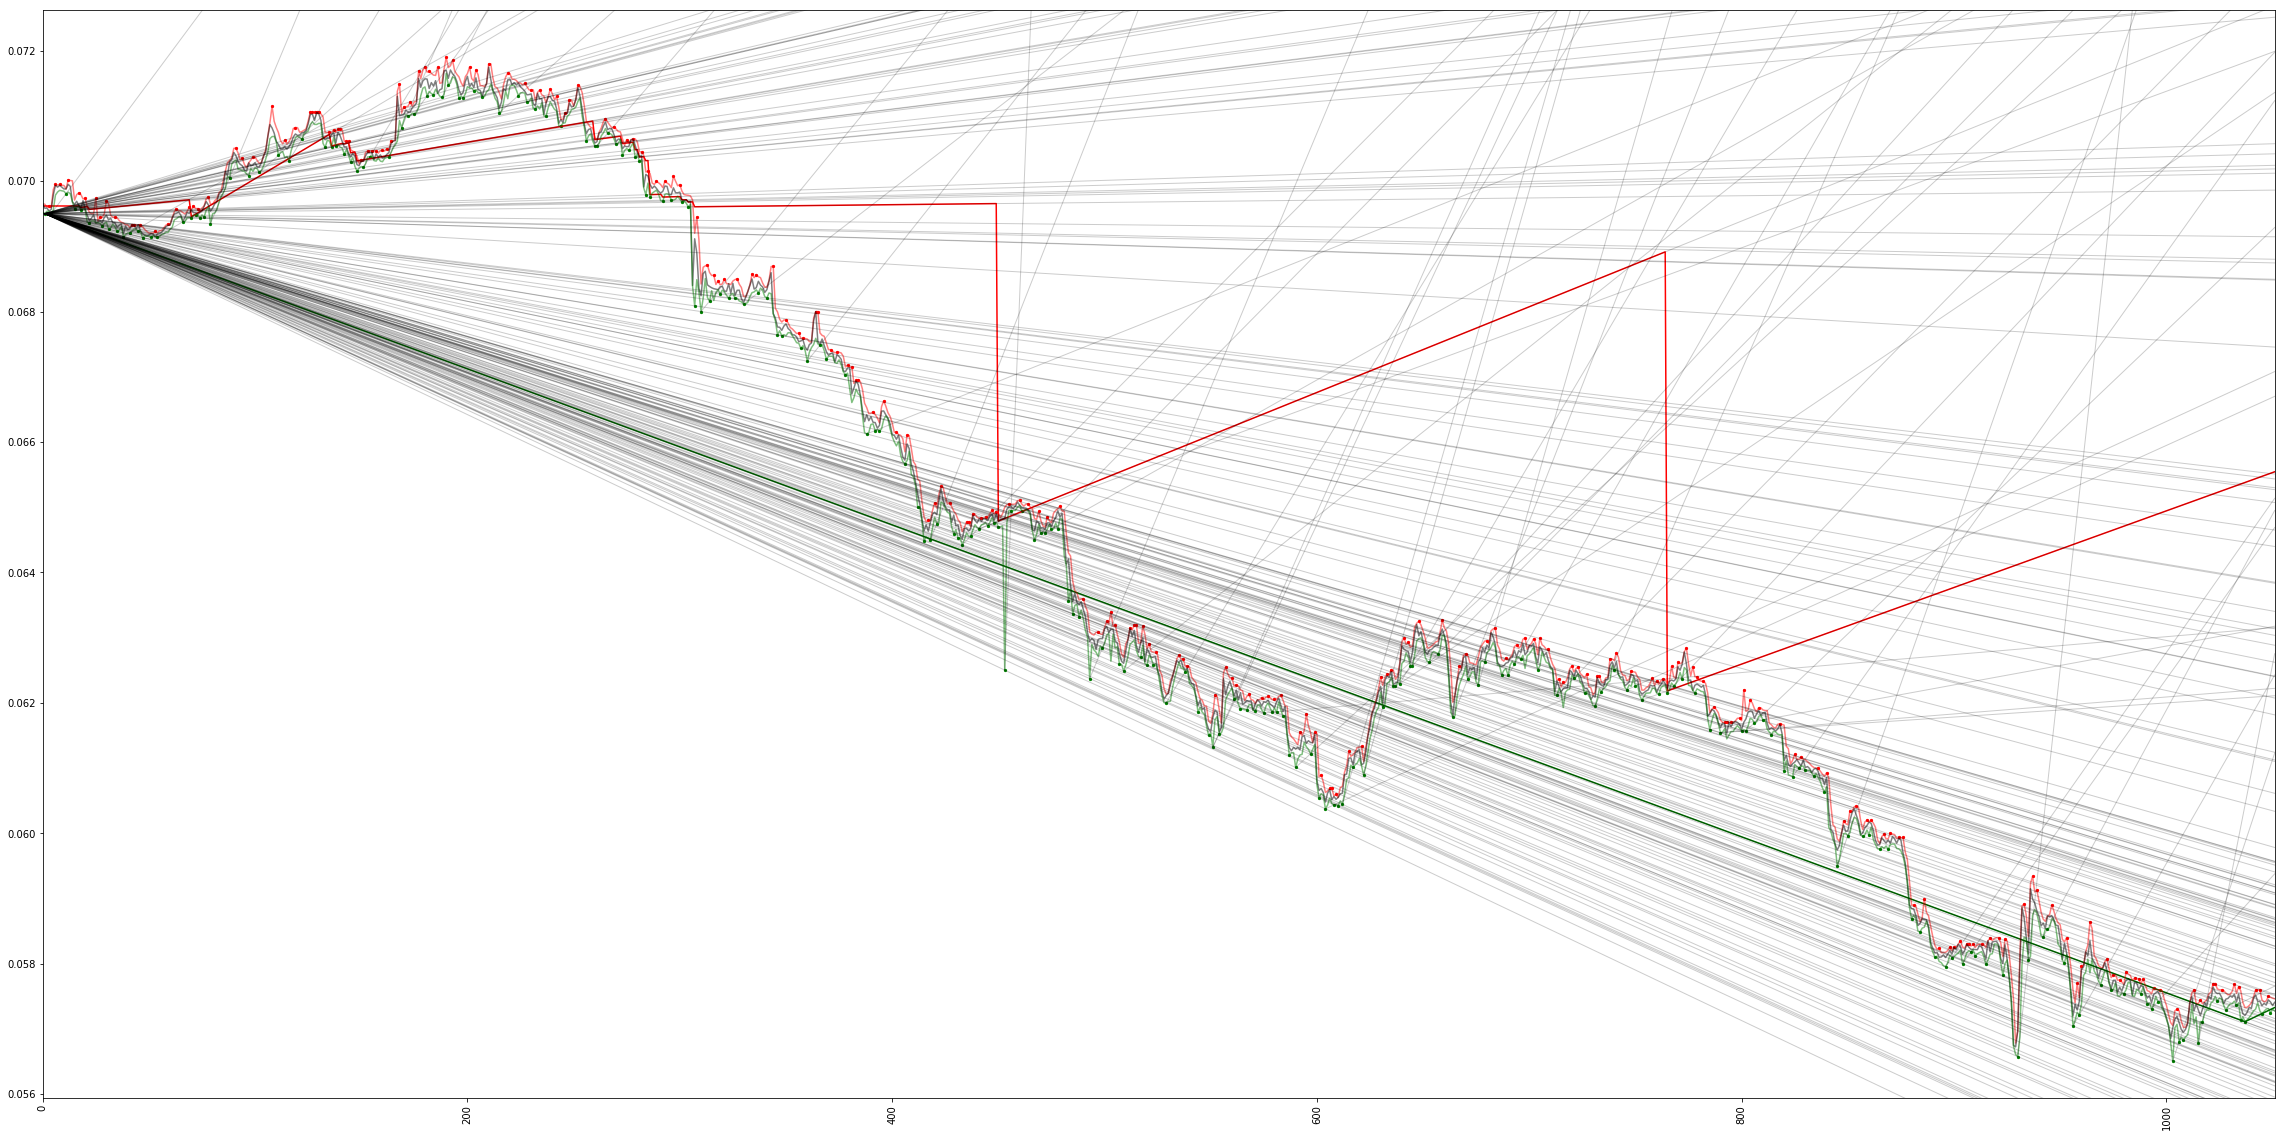

In [6]:
# plot_trends(df_concurrence, interval=ticker_interval, pair=pair, cols=[])
plot_trends(df_lightbuoy, interval=ticker_interval, pair=pair, cols=[])

In [8]:
max_drawdown(df.close.values)

0.20938562747393666